In [1]:
# Installation of required libraries
!pip install kaggle
!pip install tensorflow

In [2]:
# Call API file from KAGGLE
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emadamani","key":"9a40fd124303f20286c62c246f6b9dc1"}'}

In [3]:
# API encryption
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

In [5]:
# download dataset
!kaggle datasets download -d gauravduttaki -d andrewmvd/ocular-disease-recognition-odir5k

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
100% 1.62G/1.62G [00:49<00:00, 33.7MB/s]
100% 1.62G/1.62G [00:49<00:00, 35.4MB/s]


In [6]:
# unzip dataset
!unzip ocular-disease-recognition-odir5k.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

# librarys

In [7]:
from tensorflow.keras.losses import categorical_crossentropy as Categorical_Crossentropy
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, F1Score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import ast
import os
import re


In [8]:
def sort_photos(directory):
    # get a list of all files in the directory
    files = os.listdir(directory)

    # filter the list to only include image files (you can adjust the file extensions as needed)
    image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]

    # extract the numbers from the filenames using a regular expression
    numbers = [int(re.search(r'\d+', f).group()) for f in image_files]

    # create a list of tuples (number, filename)
    numbered_files = list(zip(numbers, image_files))

    # sort the list by the numbers
    numbered_files.sort()

    # extract the sorted filenames
    sorted_filenames = [f for _, f in numbered_files]

    return sorted_filenames

# example usage:
directory = "/content/ODIR-5K/ODIR-5K/Training Images"
sorted_photos = sort_photos(directory)

print(sorted_photos)
print(len(sorted_photos))

['0_left.jpg', '0_right.jpg', '1_left.jpg', '1_right.jpg', '2_left.jpg', '2_right.jpg', '3_left.jpg', '3_right.jpg', '4_left.jpg', '4_right.jpg', '5_left.jpg', '5_right.jpg', '6_left.jpg', '6_right.jpg', '7_left.jpg', '7_right.jpg', '8_left.jpg', '8_right.jpg', '9_left.jpg', '9_right.jpg', '10_left.jpg', '10_right.jpg', '11_left.jpg', '11_right.jpg', '12_left.jpg', '12_right.jpg', '13_left.jpg', '13_right.jpg', '14_left.jpg', '14_right.jpg', '15_left.jpg', '15_right.jpg', '16_left.jpg', '16_right.jpg', '17_left.jpg', '17_right.jpg', '18_left.jpg', '18_right.jpg', '19_left.jpg', '19_right.jpg', '20_left.jpg', '20_right.jpg', '21_left.jpg', '21_right.jpg', '22_left.jpg', '22_right.jpg', '23_left.jpg', '23_right.jpg', '24_left.jpg', '24_right.jpg', '25_left.jpg', '25_right.jpg', '26_left.jpg', '26_right.jpg', '27_left.jpg', '27_right.jpg', '28_left.jpg', '28_right.jpg', '29_left.jpg', '29_right.jpg', '30_left.jpg', '30_right.jpg', '31_left.jpg', '31_right.jpg', '32_left.jpg', '32_right.jp

In [10]:
left_eye = []
pathleft_eye = []

right_eye = []
pathright_eye = []


for filename in sorted_photos:
    # load images
    img = cv2.imread(os.path.join(directory, filename))
    # resize images
    img = cv2.resize(img,(128,128))
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # normalize pixel values
    img = img.astype('float32') / 255.0  # Normalize pixel values between 0 and 1

    # Separation of right eye and left eye images
    # append images to lists

    if "left" in filename.lower():
        left_eye.append(img)
        fl = filename.split('_')
        pathleft_eye.append(fl[0])

    elif "right" in filename.lower():
        right_eye.append(img)
        fr = filename.split('_')
        pathright_eye.append(fr[0])

print(len(left_eye))
print(len(right_eye))

3500
3500


In [11]:
""" Deleting pictures of eyes that are not paired means
that if there is a picture of the patient's left eye
but there is no picture of the right eye, then the picture of the left eye
will be deleted. """


new_pathleft_eye = []
new_pathright_eye = []
new_left_eye = []
new_right_eye = []

# First loop
for i in pathleft_eye:
    if i in pathright_eye:
        new_pathleft_eye.append(i)
        new_left_eye.append(left_eye[pathleft_eye.index(i)])

# Second loop
for j in pathright_eye:
    if j in pathleft_eye:
        new_pathright_eye.append(j)
        new_right_eye.append(right_eye[pathright_eye.index(j)])

# Update the original lists
pathleft_eye = new_pathleft_eye
pathright_eye = new_pathright_eye
left_eye = new_left_eye
right_eye = new_right_eye

# Third loop (no changes needed)
for k in pathright_eye:
    if k not in pathleft_eye:
        print(k)

print(len(left_eye))
print(len(right_eye))

3500
3500


# Obtaining data related to images from the entire dataframe

In [12]:
# Load the CSV file
df = pd.read_csv('full_df.csv')

problem = {}
# Initialize the lists
ages = []
sex = []
left_problem = []
right_problem = []
disease_labels = []

for i in pathleft_eye:
    for index, row in df.iterrows():
        # ID////////////////////////////
        if str(row['ID']) == i:
            # age////////////////////////////
            ages.append(row['Patient Age'])
            # sex////////////////////////////
            if row['Patient Sex'] == 'Male':
                sex.append(1)
            else:
                sex.append(0)
            # Left-Diagnostic Keywords/////////////////////
            left_keyword = row['Left-Diagnostic Keywords']
            left_problem.append(left_keyword)

            # Right-Diagnostic Keywords////////////////////
            right_keyword = row['Right-Diagnostic Keywords']
            right_problem.append(right_keyword)

            break

In [13]:
print(len(problem))
print(len(ages))
print(len(sex))
print(len(left_problem))
print(len(right_problem))
print(len(disease_labels))
print(ages)
print(sex)
print(left_problem)
print(right_problem)
print(disease_labels)

0
3358
3358
3358
3358
0
[69, 57, 42, 66, 53, 50, 60, 60, 59, 54, 70, 60, 60, 55, 50, 54, 57, 58, 45, 76, 55, 47, 75, 63, 63, 33, 63, 59, 62, 64, 60, 61, 68, 41, 75, 74, 62, 58, 89, 35, 55, 54, 66, 60, 69, 47, 59, 60, 67, 65, 66, 62, 63, 74, 62, 54, 59, 50, 76, 80, 56, 62, 56, 72, 43, 57, 56, 78, 67, 68, 68, 67, 46, 72, 66, 33, 61, 51, 67, 56, 41, 71, 60, 53, 28, 53, 70, 55, 46, 56, 64, 69, 62, 59, 45, 73, 55, 61, 57, 68, 54, 69, 64, 57, 67, 48, 66, 61, 65, 48, 59, 43, 47, 50, 72, 68, 71, 66, 52, 67, 62, 66, 63, 59, 56, 41, 75, 44, 59, 41, 44, 32, 72, 54, 49, 50, 57, 46, 70, 57, 62, 48, 55, 79, 67, 40, 82, 65, 61, 69, 40, 49, 76, 61, 62, 48, 65, 71, 66, 64, 59, 68, 87, 71, 56, 65, 54, 65, 45, 64, 64, 55, 69, 63, 45, 56, 55, 62, 51, 51, 66, 53, 57, 73, 65, 66, 50, 64, 62, 63, 54, 58, 67, 51, 68, 67, 70, 60, 67, 44, 70, 53, 68, 69, 36, 62, 60, 68, 56, 54, 70, 50, 58, 54, 63, 56, 60, 47, 56, 54, 67, 65, 55, 70, 62, 35, 58, 38, 67, 58, 65, 70, 49, 64, 60, 62, 77, 55, 60, 75, 62, 57, 58, 50,

#Left eye

In [14]:
# Initialize empty lists to store the left eye condition counts
left_CA = []  # Cataract
left_NON = []  # Non-proliferative retinopathy
left_GL = []  # Glaucoma
left_HY = []  # Hypertensive
left_MY = []  # Myopia
left_MA = []  # Macular degeneration
left_DR = []  # Drusen
left_NO = []  # Normal fundus

# Iterate through the 'left_problem' list
for i in left_problem:
    # Check if the current problem in the list contains the keyword 'cataract'
    if 'cataract' in i:
        # Get the index of the current problem in the 'left_problem' list
        index = left_problem.index(i)
        # Append the corresponding left eye value to the 'left_CA' list
        left_CA.append(left_eye[index])

    # Check if the current problem in the list contains the phrase 'non proliferative retinopathy'
    elif "non proliferative retinopathy" in i:
        index = left_problem.index(i)
        left_NON.append(left_eye[index])

    # Check if the current problem in the list contains the keyword 'glaucoma'
    elif 'glaucoma' in i:
        index = left_problem.index(i)
        left_GL.append(left_eye[index])

    # Check if the current problem in the list contains the keyword 'hypertensive'
    elif 'hypertensive' in i:
        index = left_problem.index(i)
        left_HY.append(left_eye[index])

    # Check if the current problem in the list contains the keyword 'myopia'
    elif 'myopia' in i:
        index = left_problem.index(i)
        left_MY.append(left_eye[index])

    # Check if the current problem in the list contains the phrase 'macular degeneration'
    elif 'macular degeneration' in i:
        index = left_problem.index(i)
        left_MA.append(left_eye[index])

    # Check if the current problem in the list contains the keyword 'drusen'
    elif 'drusen' in i:
        index = left_problem.index(i)
        left_DR.append(left_eye[index])

    # Check if the current problem in the list contains the phrase 'normal fundus'
    elif 'normal fundus' in i:
        index = left_problem.index(i)
        left_NO.append(left_eye[index])
    else:
        continue

#Right eye

In [15]:
# Initialize empty lists to store right eye values for different eye conditions
right_CA = []  # Cataract
right_NON = []  # Non-proliferative retinopathy
right_GL = []  # Glaucoma
right_HY = []  # Hypertensive
right_MY = []  # Myopia
right_MA = []  # Macular degeneration
right_DR = []  # Drusen
right_NO = []  # Normal fundus

# Iterate through the right_problem list
for i in right_problem:
    # Check if the problem contains the keyword 'cataract'
    if 'cataract' in i:
        # Get the index of the current problem in the right_problem list
        index = right_problem.index(i)
        # Append the corresponding right eye value to the right_CA list
        right_CA.append(right_eye[index])

    # Check if the problem contains the phrase 'non proliferative retinopathy'
    elif "non proliferative retinopathy" in i:
        index = right_problem.index(i)
        right_NON.append(right_eye[index])

    # Check if the problem contains the keyword 'glaucoma'
    elif 'glaucoma' in i:
        index = right_problem.index(i)
        right_GL.append(right_eye[index])

    # Check if the problem contains the keyword 'hypertensive'
    elif 'hypertensive' in i:
        index = right_problem.index(i)
        right_HY.append(right_eye[index])

    # Check if the problem contains the keyword 'myopia'
    elif 'myopia' in i:
        index = right_problem.index(i)
        right_MY.append(right_eye[index])

    # Check if the problem contains the phrase 'macular degeneration'
    elif 'macular degeneration' in i:
        index = right_problem.index(i)
        right_MA.append(right_eye[index])

    # Check if the problem contains the keyword 'drusen'
    elif 'drusen' in i:
        index = right_problem.index(i)
        right_DR.append(right_eye[index])

    # Check if the problem contains the phrase 'normal fundus'
    elif 'normal fundus' in i:
        index = right_problem.index(i)
        right_NO.append(right_eye[index])

    else:
        continue


#DATASET

In [16]:
# Creating data
# Sorting images and labels and shuffling
dataset = []
def dataset_generator(right_img_catgory, left_img_catgory, label):
    import random

    combined_list = right_img_catgory + left_img_catgory
    random.shuffle(combined_list)

    for i in combined_list:
        dataset.append([np.array(i), np.array(label)])
    random.shuffle(dataset)
    return dataset

In [17]:
dataset = dataset_generator(right_NO,left_NO,0)
dataset = dataset_generator(right_CA,left_CA,1)
dataset = dataset_generator(right_NON,left_NON,2)
dataset = dataset_generator(right_GL,left_GL,3)
dataset = dataset_generator(right_HY,left_HY,4)
dataset = dataset_generator(right_MY,left_MY,5)
dataset = dataset_generator(right_MA,left_MA,6)
dataset = dataset_generator(right_DR,left_DR,7)
print(len(dataset))

5343


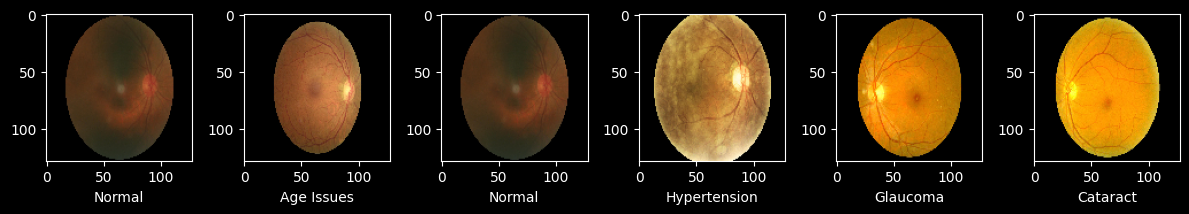

In [23]:
plt.figure(figsize=(12,7))
for i in range(6):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]


    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    elif category == 7:
        label = "drusen"

    plt.subplot(2,6,i+1)
    plt.style.use('dark_background')
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [24]:
# Separation of labels and data

label = []
new_dataset = []
for i in dataset:
    new_dataset.append(i[0])
    label.append(i[1])
print(len(label))
print(len(new_dataset))

5343
5343


In [27]:
# Converting data and labels to an array
dataset = np.array(new_dataset)
label = np.array(label)

# Separate data into the most data and test
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.15, random_state=42)


print(len(x_train))
print(len(y_train))

4541
4541


In [26]:
# Using the pre-trained vgg16 model as the base model
img_rows, img_cols = 128, 128
model_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

# turne off trainable
for layer in model_base.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [28]:
# Building a neural network for data classification
def neural_network(bottom_model, num_classes):

    X = bottom_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dense(num_classes, activation='softmax')(X)
    return X


nm_class = 8  # Number of classes
# model
result = neural_network(model_base, nm_class)

# creat model
model_1 = Model(inputs=model_base.input, outputs=result)

# Convert the target labels to one-hot encoded vectors
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model fit
model_1.fit(x_train, y_train, epochs=35, validation_split=0.1)

Epoch 1/35
128/128 [==============================] - 16s 79ms/step - loss: 1.3834 - accuracy: 0.5433 - val_loss: 1.2537 - val_accuracy: 0.5407
Epoch 2/35
128/128 [==============================] - 6s 45ms/step - loss: 1.1773 - accuracy: 0.6055 - val_loss: 1.1085 - val_accuracy: 0.6000
Epoch 3/35
128/128 [==============================] - 6s 45ms/step - loss: 1.0487 - accuracy: 0.6397 - val_loss: 0.9898 - val_accuracy: 0.6044
Epoch 4/35
128/128 [==============================] - 6s 45ms/step - loss: 0.9515 - accuracy: 0.6750 - val_loss: 0.8934 - val_accuracy: 0.7187
Epoch 5/35
128/128 [==============================] - 6s 45ms/step - loss: 0.8706 - accuracy: 0.7230 - val_loss: 0.8151 - val_accuracy: 0.7758
Epoch 6/35
128/128 [==============================] - 6s 44ms/step - loss: 0.8029 - accuracy: 0.7621 - val_loss: 0.7479 - val_accuracy: 0.7890
Epoch 7/35
128/128 [==============================] - 6s 45ms/step - loss: 0.7474 - accuracy: 0.7829 - val_loss: 0.6965 - val_accuracy: 0.819

In [29]:
from sklearn.metrics import accuracy_score, f1_score

# predection for f1 score and accuracy
y_pred = model_1.predict(x_test)
y_pred = np.argmax(y_pred, axis=1) # Convert predictions to class labels

# Calculate the F1-score using 'macro' averaging
f1 = f1_score(y_test, y_pred, average='macro')
print("F1-score:", f1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the model to get loss and accuracy on test data
loss, accuracy = model_1.evaluate(x_test, y_test, verbose=0)
print("Loss:", loss)

26/26 [==============================] - 2s 74ms/step
F1-score: 0.8783240133932985
Accuracy: 0.9351620947630923
Loss: 0.31855398416519165


#Diagnosis of a person's disease using the problem of the patient's right eye, the patient's left eye, the patient's age and the patient's sex with SVM

In [30]:
# Coding labels and sex and receiving the necessary data from the data frame for classification and training svm

# Load the CSV file
df = pd.read_csv('full_df.csv')

# Define the label and problem dictionaries
labels_int = ["['N']", "['D']", "['G']", "['C']", "['A']", "['H']", "['M']", "['O']"]
# Initialize the lists
dataset2 = []
label2 = []

# Get the desired data only with the topic of these 8 categories from the database
"""
If there are any other category except these 8 categories,
the data of that row will not be transferred here from the dataframe.
"""
for index, row in df.iterrows():
    a = 0
    b = 0
    s = 0


    if 'normal fundus' in row['Left-Diagnostic Keywords']:
        a = 0
    elif 'cataract' in row['Left-Diagnostic Keywords']:
        a = 1
    elif "non proliferative retinopathy" in row['Left-Diagnostic Keywords']:
        a = 2
    elif 'glaucoma' in row['Left-Diagnostic Keywords']:
        a = 3
    elif 'hypertensive' in row['Left-Diagnostic Keywords']:
        a = 4
    elif 'myopia' in row['Left-Diagnostic Keywords']:
        a = 5
    elif 'macular degeneration' in row['Left-Diagnostic Keywords']:
        a = 6
    elif 'drusen' in row['Left-Diagnostic Keywords']:
        a = 7
    else:
        continue

    if 'normal fundus' in row['Right-Diagnostic Keywords']:
        b = 0
    elif 'cataract' in row['Right-Diagnostic Keywords']:
        b = 1
    elif "non proliferative retinopathy" in row['Right-Diagnostic Keywords']:
        b = 2
    elif 'glaucoma' in row['Right-Diagnostic Keywords']:
        b = 3
    elif 'hypertensive' in row['Right-Diagnostic Keywords']:
        b = 4
    elif 'myopia' in row['Right-Diagnostic Keywords']:
        b = 5
    elif 'macular degeneration' in row['Right-Diagnostic Keywords']:
        b = 6
    elif 'drusen' in row['Right-Diagnostic Keywords']:
        b = 7

    else:
        continue

    # sex 0 or 1
    # if row['Patient Sex'] == 'Male':
    #     s = 1
    # elif row['Patient Sex'] == 'Female':
    #     s = 0

    # make dataset
    dataset2.append([a, b]) # ([row['Patient Age'], s, a, b])
    # make labels
    label2.append(labels_int.index(row['labels']))

# print
print(len(dataset2))
print(len(label2))

4374
4374


# SVM

In [31]:
from sklearn.metrics import f1_score
# Assuming your dataset is in a pandas DataFrame 'df'
X = dataset2
y = label2

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
model_2 = SVC(kernel='rbf', C=1.0, gamma='auto')
model_2.fit(X_train, y_train)

# Evaluate the model
accuracy = model_2.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

# f1 score

# predection for f1 score
y_pred = model_2.predict(X_test)
# Calculate the F1-score using 'macro' averaging
f1 = f1_score(y_test, y_pred, average='macro')
print("F1-score:", f1)

Accuracy: 0.90
F1-score: 0.8706176421017016


In [32]:
input_left_eye = ''
input_right_eye = ''
age = 64 # in years
sex = 1 # 0 for female, 1 for male

def prossec(image):

    # load images
    img = cv2.imread(image)

    # Check if image loaded successfully
    if img is None:
        print(f"Error: Could not load image from {image}")
        return None  # or handle the error appropriately

    # resize images
    img = cv2.resize(img,(128,128))
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # normalize pixel values
    img = img.astype('float32') / 255.0

    # Add an extra dimension for the batch
    img = np.expand_dims(img, axis=0)

    return img # Return preprocessed image

L = model_1.predict(prossec(input_left_eye))
R = model_1.predict(prossec(input_right_eye))

# ... (rest of the code remains unchanged)

print(L)
print(R, '\n')

# Extract the predicted class or probabilities (depending on model_1)
L = np.argmax(L, axis=1)  # Replace with appropriate extraction if needed
R = np.argmax(R, axis=1)  # Replace with appropriate extraction if needed

def answer(x):
    if x == [0]:
        y = "Normal"
    elif x == [1] :
        y = "Cataract"
    elif x == [2]:
        y = "non proliferative retinopathy"
    elif x == [3]:
        y = "Glaucoma"
    elif x == [4]:
        y = "Hypertension"
    elif x == [5]:
        y = "Myopia"
    elif x == [6]:
        y = "macular degeneration ,Diabetes"
    elif x == [7]:
        y = "drusen, Age Issues"
    else:
        y = "Other"
    return y

# ///////////////////////////////////////////////
# Reshape the input for prediction
input_data = np.array([L[0], R[0]]).reshape(1, -1) # ([age, sex, L[0], R[0]]).reshape(1, -1)  # Reshape to 2D array

result = model_2.predict(input_data)
# //////////////////////////////////////////////

# result

print('Left eye: '+answer(L))
print('Right eye: '+answer(R))

labels_int = ["Normal", "Diabetes", "Glaucoma", "Cataract", "Age related Macular Degeneration", "Hypertension", "Pathological Myopia", "Other diseases/abnormalities"]
print("person's disease: "+labels_int[int(result)]+'\n')




1/1 [==============================] - 0s 19ms/step
[[0.8816548  0.00353245 0.00795283 0.00839766 0.03090633 0.0134107
  0.03371342 0.02043171]]
[[0.4258335  0.10411106 0.05499989 0.05209598 0.12284032 0.05995704
  0.14633352 0.0338287 ]] 

Left eye: Normal
Right eye: Normal
person's disease: Normal



<ipython-input-32-b95b4cc2daf8>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("person's disease: "+labels_int[int(result)]+'\n')


In [33]:
import joblib

# Save the model using joblib
joblib.dump(model_1, 'svm_model_1.pkl')
joblib.dump(model_2, 'svm_model_2.pkl')

['svm_model_2.pkl']